<a href="https://colab.research.google.com/github/xcsengody/DP/blob/master/xcsengody.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#from google.colab import files
#dataset.to_csv('dataset.csv')

In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
root='/content/drive/My Drive/DP/'

Mounted at /content/drive


In [7]:
!pip -q install geoip2;
!apt-get -o Dpkg::Options::="--force-confmiss" install --reinstall netbase;

!pip -q install folium==0.2.1;

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 1 reinstalled, 0 to remove and 32 not upgraded.
Need to get 12.7 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 netbase all 5.4 [12.7 kB]
Fetched 12.7 kB in 1s (14.2 kB/s)
(Reading database ... 145612 files and directories currently installed.)
Preparing to unpack .../archives/netbase_5.4_all.deb ...
Unpacking netbase (5.4) over (5.4) ...
Setting up netbase (5.4) ...


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import os
import sys
import socket
import json
import seaborn as sns
import pylab as pl
import geoip2.database
from scipy import stats
from pylab import rcParams
from sklearn import preprocessing
from collections import Counter
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import (SMOTE,SVMSMOTE,ADASYN)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
pd.set_option('display.max_rows', 500);
pd.set_option('display.max_columns', None);
rcParams['figure.figsize'] = 15, 8;
sns.set(style="whitegrid");

In [0]:
def makePlot(x,y,title,l):
  plt.figure();
  fig,ax = plt.subplots();
  mean_value=[np.mean(y)]*len(x);
  std_value=[np.std(y)]*len(x);
  data_line = ax.scatter(x, y, label='Data', marker='.', color="deepskyblue");
  mean_line = ax.plot(x, mean_value, label='Mean', linestyle='--', color="darkorange");
  std_line = ax.plot(x, std_value, label='STD', linestyle='-', color="olive");
  if l is not None: 
    line_value=[l]*len(x);
    threshold_line = ax.plot(x, line_value, label='Threshold', linestyle=':', color="red");
  legend = ax.legend(loc='upper right');
  plt.title(title);
  plt.show()

def makeMultiPlot(x1,y1,x2,y2,title):
  plt.figure();
  plt.scatter(x1, y1, label='Data_1', marker='o', color="deepskyblue");
  plt.scatter(x2, y2, label='Data_2', marker='o', color="darkorange");
  plt.legend(loc='upper right');
  plt.title(title);
  plt.show()

def plot_distribution(X, y, label='Classes'):
  colors = ['red','orange','lightgreen','darkgreen','lightblue','blue','yellow','pink','purple']
  markers = ['.']
  for l, c, m in zip(np.unique(y), colors, markers):
      plt.scatter(
          X[y==l, 0],
          X[y==l, 1],
          c=c, label=l, marker=m
      )
  plt.title(label)
  plt.legend(loc='upper right')
  plt.show()

def getProtocolNumber(x):
  try:
    return socket.getprotobyname(x);
  except:
    return -1;

def portType(x):
  #Ports range:
  #Well known: 0-1023 (1)
  #Registered: 1024-49151 (2)
  #Private: 49152-65535 (3)
  if x >= 0 and x < 1024:
    return 1;
  elif x >= 1024 and x < 49152:
    return 2;
  elif x >= 49152 and x < 65536:
    return 3;

def isPrivateIP(x):
  #192.168.0.0 - 192.168.255.255
  #172.16.0.0 - 172.31.255.255
  #10.0.0.0 - 10.255.255.255
  if (re.search('192\.168\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])',x)) or (re.search('172\.16|31\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])',x)) or (re.search('10\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])',x)) or (re.search('127\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])',x)):
    return True
  else:
    return False

def isLocalhostIP(x):
  #127.0.0.1
  if (re.search('127\.0\.0\.1',x)):
    return True
  else:
    return False

def isMulticastIP(x):
  #224.0.0.0 - 239.255.255.255
  if (re.search('22[4-9]|23[0-9]\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])',x)):
    return True
  else:
    return False

def getIPLocation(ip):
  try:
    location = reader.country(ip);
    #result = location.country.names['en']+" ("+location.country.iso_code+")";
    return location.country.iso_code;
  except:
    if isPrivateIP(ip):
      return "Private";
    elif isLocalhostIP(ip):
      return "Localhost";
    elif isMulticastIP(ip):
      return "Multicast"; 

def closeReader():
  reader.close();

def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
  from IPython.display import HTML
  import pandas as pd
  import numpy as np
  import base64
  csv = df.to_csv()
  b64 = base64.b64encode(csv.encode())
  payload = b64.decode()
  html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
  html = html.format(payload=payload,title=title,filename=filename)
  return HTML(html)

In [0]:
path = root+'GeoLite2-Country.mmdb';
reader=geoip2.database.Reader(path);

In [12]:
path = root+"Dataset/NUSW-NB15_features.csv";
df = pd.read_csv(path, delimiter=',', encoding='unicode_escape', low_memory=False, skipinitialspace=True, skip_blank_lines=True, verbose=True);
features = df.Name

Tokenization took: 0.06 ms
Type conversion took: 3.12 ms
Parser memory cleanup took: 0.01 ms


In [14]:
path = root+"Dataset/UNSW-NB15_1.csv";
dataset = pd.read_csv(path, delimiter=',', names=features, encoding='utf-8', low_memory=False, skipinitialspace=True, skip_blank_lines=True, verbose=True);

Tokenization took: 2527.06 ms
Type conversion took: 4963.96 ms
Parser memory cleanup took: 28.46 ms


In [17]:
print("Number of rows: {}\nNumber of features: {}".format(dataset.shape[0],dataset.shape[1]))

Number of rows: 700001
Number of features: 49


In [18]:
print("NaN columns {}".format(dataset.columns[dataset.isna().any()].tolist()))

NaN columns ['attack_cat']


In [0]:
dataset.attack_cat = dataset.attack_cat.fillna('Normal')

In [20]:
dataset.state.value_counts()

FIN    487911
CON    187505
INT     21799
REQ      2429
CLO       111
URH       108
RST        74
ECO        26
ACC        22
PAR         4
URN         2
TST         2
MAS         2
no          2
TXD         2
ECR         2
Name: state, dtype: int64

In [0]:
dataset = dataset[dataset.state.apply(lambda x: x != 'no')]

In [0]:
dataset.service = dataset.service.replace(to_replace ="-", value ="NUSER");

In [23]:
dataset[dataset.sport.apply(lambda x: x == '-')]

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
82531,175.45.176.1,-,149.171.126.12,0x20205321,esp,INT,0.0,200,0,254,0,0,0,NUSER,200000000.0,0.0,2,0,0,0,0,0,100,0,0,0,0.0,0.0,1421930680,1421930680,0.004,0.000,0.0,0.0,0.0,0,2,0,0,0,12,12,4,4,2,1,4,Normal,0
143351,149.171.126.19,-,175.45.176.1,48879,icmp,ECR,0.0,0,156,0,254,0,0,NUSER,56727272.0,0.0,0,2,0,0,0,0,0,78,0,0,0.0,0.0,1421932729,1421932729,0.000,0.011,0.0,0.0,0.0,0,0,0,0,0,2,2,2,2,2,1,2,Normal,0


In [0]:
dataset = dataset[dataset.sport.apply(lambda x: x != '-')]

In [25]:
dataset[dataset.dsport.apply(lambda x: x == '-')]

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
36372,10.40.85.1,0x000b,175.45.176.2,-,icmp,TXD,0.0,264,0,64,0,0,0,NUSER,1.248172e+04,0.0,3,0,0,0,0,0,88,0,0,0,16.4055,0.0,1421928800,1421928800,56.40250,0.0,0.0,0.0,0.0,0,0,0,0,0,2,2,2,2,1,2,2,Normal,0
45816,175.45.176.3,768,149.171.126.19,-,icmp,URN,0.0,120,0,255,0,0,0,NUSER,2.191031e+05,0.0,3,0,0,0,0,0,40,0,0,0,1.4565,0.0,1421929211,1421929211,1.46050,0.0,0.0,0.0,0.0,0,0,0,0,0,6,4,4,4,2,2,4,Normal,0
47316,10.40.85.1,0x000c,175.45.176.3,-,icmp,PAR,0.0,147,0,64,0,0,0,NUSER,0.000000e+00,0.0,1,0,0,0,0,0,147,0,0,0,0.0000,0.0,1421929277,1421929277,0.00000,0.0,0.0,0.0,0.0,0,0,0,0,0,2,2,2,2,1,2,2,Normal,0
72914,175.45.176.3,4352,149.171.126.13,-,icmp,MAS,0.0,78,0,254,0,0,0,NUSER,2.836364e+07,0.0,2,0,0,0,0,0,39,0,0,0,0.0000,0.0,1421930319,1421930319,0.01100,0.0,0.0,0.0,0.0,0,0,0,0,0,2,2,2,2,1,2,2,Normal,0
116472,10.40.85.1,0x000c,175.45.176.2,-,icmp,PAR,0.0,2800,0,64,0,0,0,NUSER,1.041973e+03,0.0,20,0,0,0,0,0,140,0,0,0,222.7920,0.0,1421931785,1421931805,1074.88375,0.0,0.0,0.0,0.0,0,0,0,0,0,2,2,2,2,1,2,2,Normal,0
139328,175.45.176.1,3328,149.171.126.10,-,icmp,TST,0.0,86,0,254,0,0,0,NUSER,3.127273e+07,0.0,2,0,0,0,0,0,43,0,0,0,0.0000,0.0,1421932579,1421932579,0.01100,0.0,0.0,0.0,0.0,0,0,0,0,0,3,2,2,9,1,2,2,Normal,0


In [0]:
dataset = dataset[dataset.dsport.apply(lambda x: x != '-')]

In [0]:
dataset.sport = dataset.sport.apply(lambda x: int(x,16) if re.search('0x.*', x) else x)

In [0]:
dataset.dsport = dataset.dsport.apply(lambda x: int(x,16) if re.search('0x.*', x) else x)

In [29]:
dataset[dataset.sport.apply(lambda x: int(x) > 65535)].shape[0]

0

In [30]:
dataset[dataset.dsport.apply(lambda x: int(x) > 65535)].shape[0]

1

In [0]:
dataset = dataset[dataset.sport.apply(lambda x: int(x) <= 65535)]
dataset = dataset[dataset.dsport.apply(lambda x: int(x) <= 65535)]

In [32]:
dataset[dataset.dur.apply(lambda x: float(x) >= 8000)]

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
687664,10.40.182.1,0,10.40.182.3,0,arp,CON,8786.637695,644,1058,0,0,0,0,NUSER,0.560852,0.921399,23,23,0,0,0,0,28,46,0,0,0.0,0.0,1421945643,1421954430,0.000,0.0,0.0,0.0,0.0,0,0,0,0,0,2,2,2,2,2,2,2,Normal,0
687665,10.40.182.1,0,10.40.182.3,0,arp,CON,8786.637695,644,1058,0,0,0,0,NUSER,0.560852,0.921399,23,23,0,0,0,0,28,46,0,0,0.0,0.0,1421945643,1421954430,0.000,0.0,0.0,0.0,0.0,0,0,0,0,0,2,2,2,2,2,2,2,Normal,0
688467,10.40.85.1,0,224.0.0.5,0,ospf,REQ,8760.776367,5376,0,1,0,0,0,NUSER,4.823182,0.000000,84,0,0,0,0,0,64,0,0,0,0.0,0.0,1421945649,1421954459,10000.882,0.0,0.0,0.0,0.0,0,0,0,0,0,2,4,4,2,2,4,2,Normal,0
688468,10.40.182.1,0,224.0.0.5,0,ospf,REQ,8760.777344,5376,0,1,0,0,0,NUSER,4.823182,0.000000,84,0,0,0,0,0,64,0,0,0,0.0,0.0,1421945649,1421954459,10000.883,0.0,0.0,0.0,0.0,0,0,0,0,0,2,4,4,2,2,4,2,Normal,0
688469,10.40.85.1,0,224.0.0.5,0,ospf,REQ,8760.776367,5376,0,1,0,0,0,NUSER,4.823182,0.000000,84,0,0,0,0,0,64,0,0,0,0.0,0.0,1421945649,1421954459,10000.882,0.0,0.0,0.0,0.0,0,0,0,0,0,2,4,4,2,2,4,2,Normal,0
688470,10.40.182.1,0,224.0.0.5,0,ospf,REQ,8760.777344,5376,0,1,0,0,0,NUSER,4.823182,0.000000,84,0,0,0,0,0,64,0,0,0,0.0,0.0,1421945649,1421954459,10000.883,0.0,0.0,0.0,0.0,0,0,0,0,0,2,4,4,2,2,4,2,Normal,0


In [0]:
dataset = dataset[dataset.dur.apply(lambda x: float(x) < 8000)]
q = dataset.dur.quantile(0.999995)
test_d=dataset[dataset.dur < q]

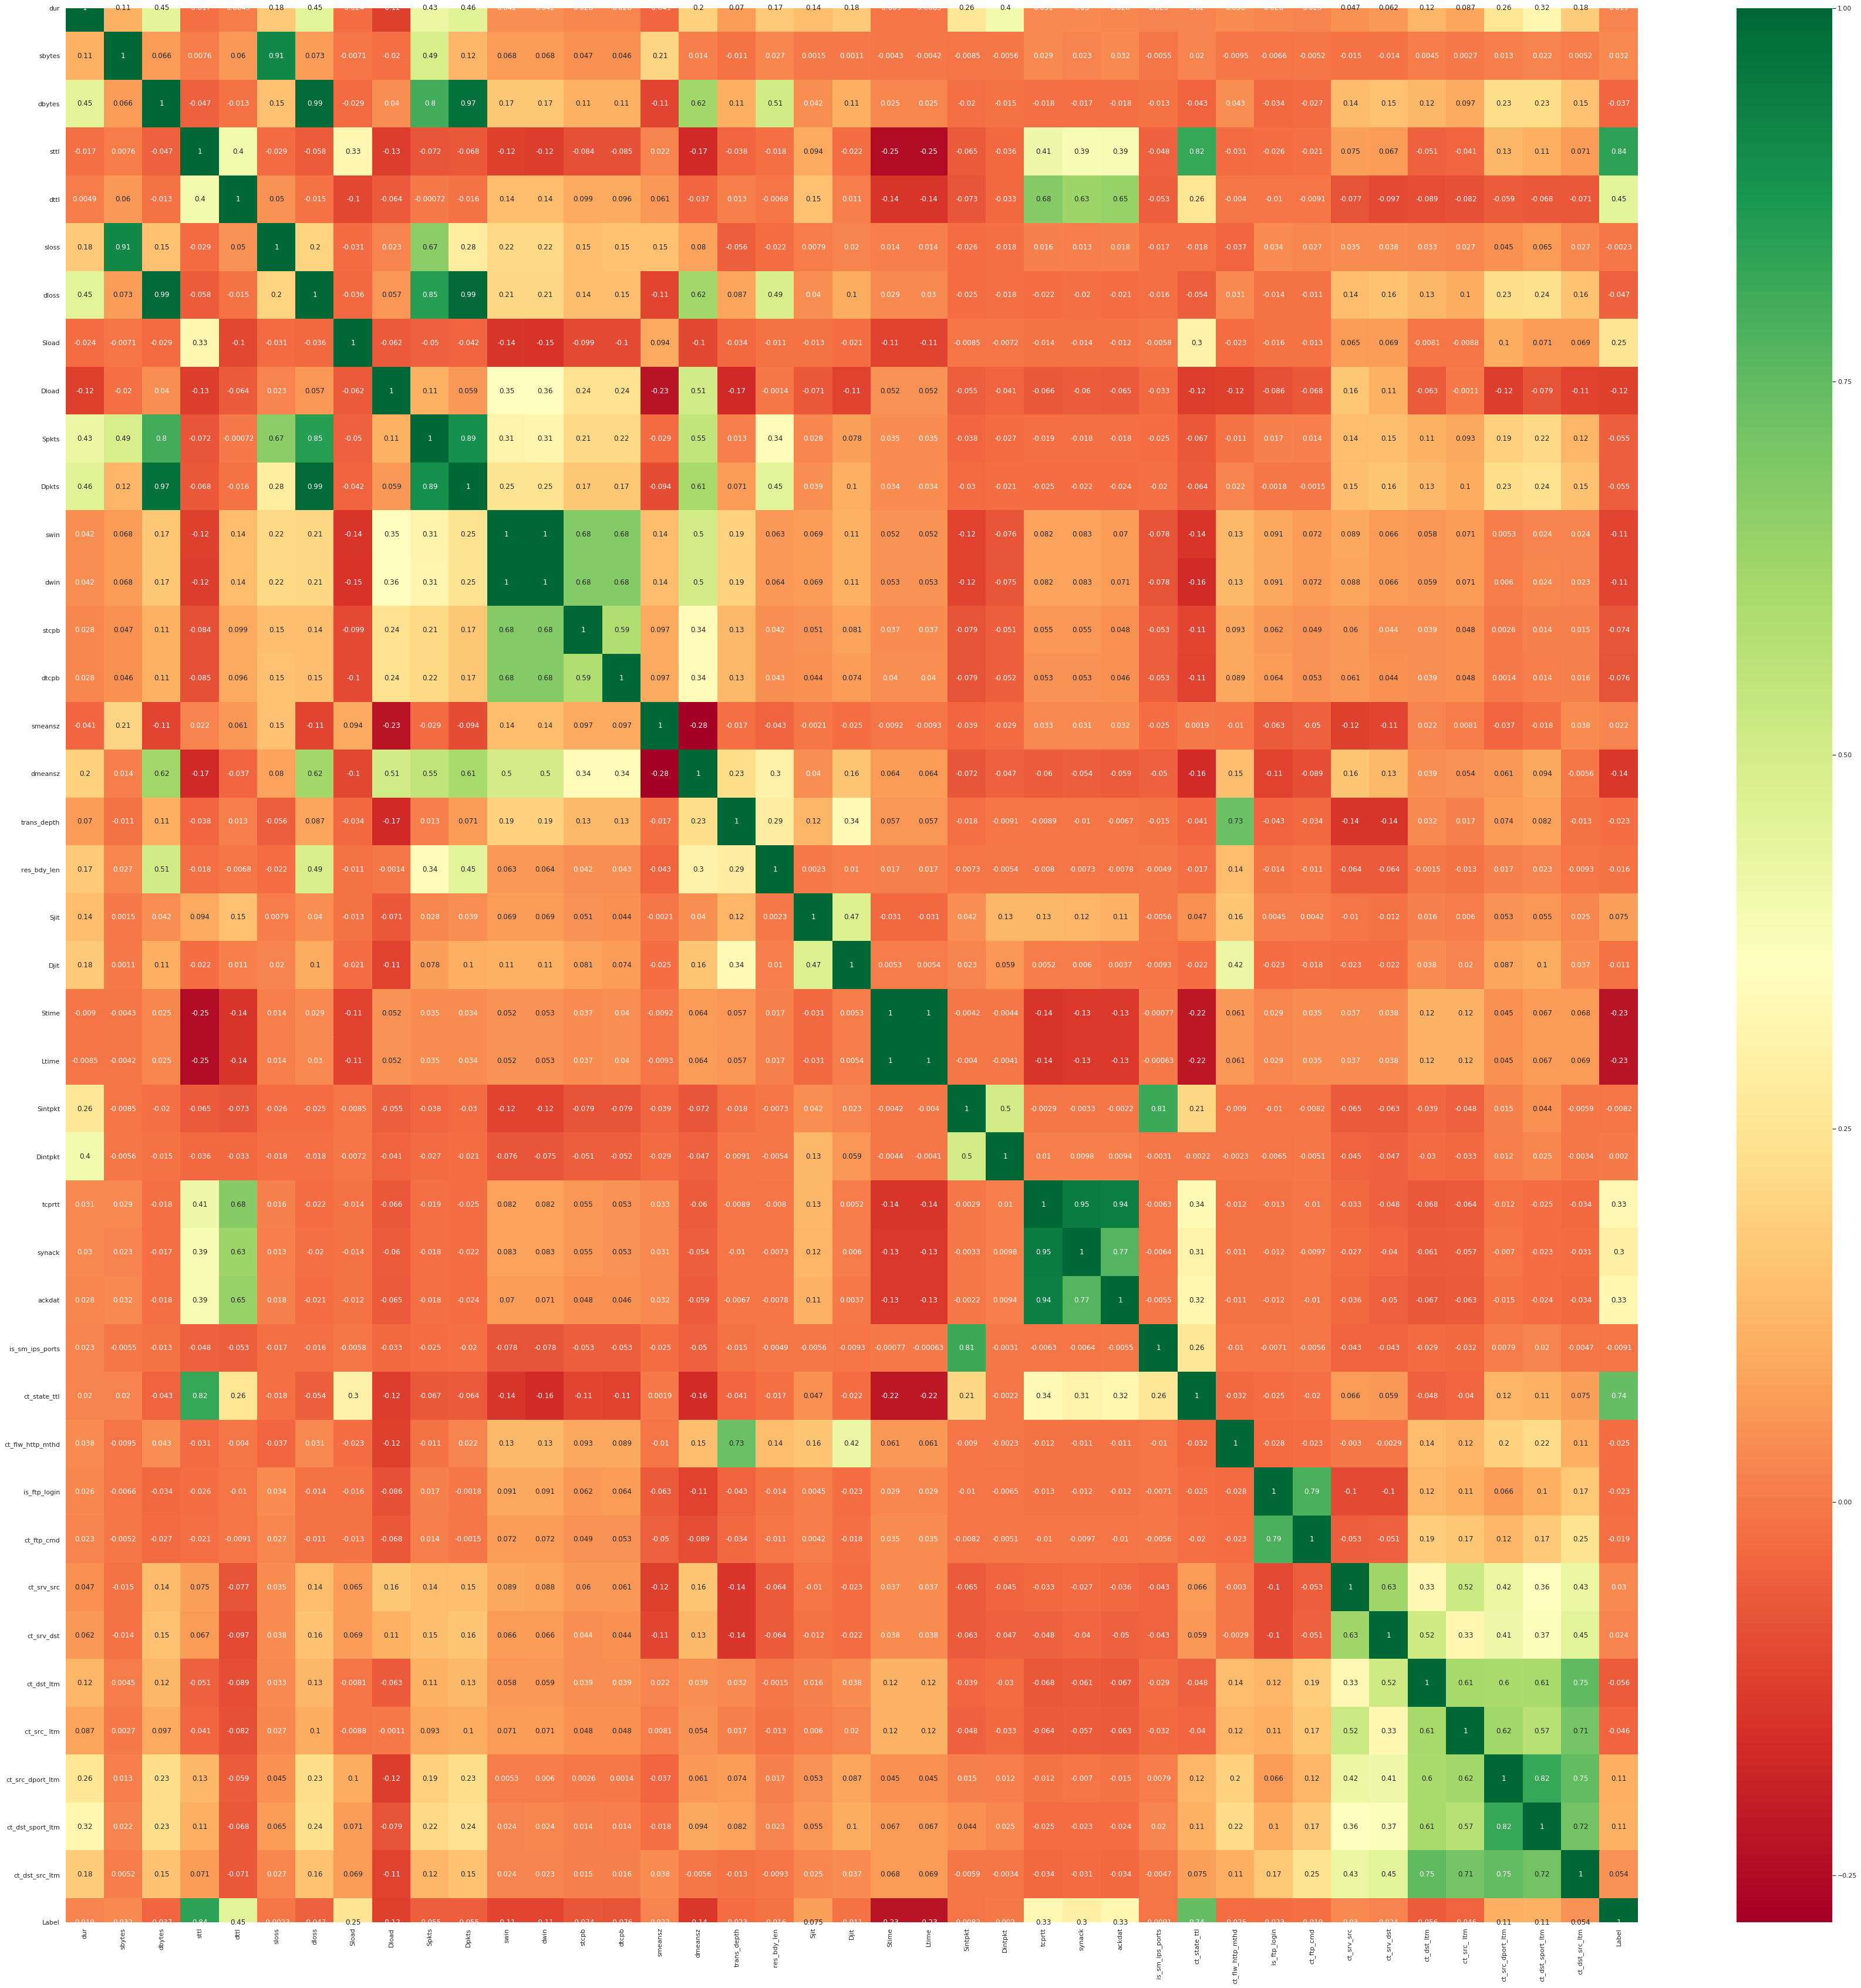

In [34]:
#Correlation matrix
corrmat = dataset.corr()
top_corr_features = corrmat.index
pl.figure(figsize=(60,60))
g=sns.heatmap(dataset[top_corr_features].corr(method='pearson', min_periods=1),annot=True,cmap="RdYlGn")

In [35]:
path = root+"Dataset/protocol-numbers.csv";
protocol_numbers = pd.read_csv(path, delimiter=',', encoding='utf-8', low_memory=False, skipinitialspace=True, skip_blank_lines=True, verbose=True);

protocol_numbers=protocol_numbers[protocol_numbers.Keyword.notnull()];
protocol_numbers.reindex();

Tokenization took: 0.14 ms
Type conversion took: 0.83 ms
Parser memory cleanup took: 0.01 ms


In [0]:
dataset.insert(2, "sporttype", 0)
dataset.insert(5, "dsporttype", 0)

In [0]:
dataset.sporttype = dataset.sport.astype(int).apply(lambda x: portType(x))
dataset.dsporttype = dataset.dsport.astype(int).apply(lambda x: portType(x))

In [0]:
protocols = dataset.proto.unique();
protocols_json = {};

for p in protocols:
  n=-1
  for r in protocol_numbers.itertuples():
    if r.Keyword.lower() == p:
      n = int(r.Decimal);
      break
  protocols_json[p] = n;

protocols_mapping = json.dumps(protocols_json)

In [0]:
protocols_mapping = {"udp": 17, "arp": 143, "tcp": 6, "ospf": 89, "icmp": 1, "igmp": 2, "sctp": 132, "udt": 144, "sep": 145, "sun-nd": 77, "swipe": 53, "mobile": 55, "pim": 103, "rtp": 146, "ipnip": 4, "ip": 147, "ggp": 3, "st2": 5, "egp": 8, "cbt": 7, "emcon": 14, "nvp": 11, "igp": 9, "xnet": 15, "argus": 13, "bbn-rcc": 10, "chaos": 16, "pup": 12, "hmp": 20, "mux": 18, "dcn": 19, "prm": 21, "trunk-1": 23, "xns-idp": 22, "trunk-2": 24, "leaf-1": 25, "leaf-2": 26, "irtp": 28, "rdp": 27, "iso-tp4": 29, "netblt": 30, "mfe-nsp": 31, "merit-inp": 32, "3pc": 34, "xtp": 36, "idpr": 35, "tp++": 39, "ddp": 37, "idpr-cmtp": 38, "ipv6": 41, "il": 40, "idrp": 45, "ipv6-frag": 44, "sdrp": 42, "ipv6-route": 43, "gre": 47, "rsvp": 46, "mhrp": 148, "bna": 49, "i-nlsp": 52, "narp": 54, "ipv6-no": 59, "tlsp": 56, "skip": 57, "ipv6-opts": 60, "any": 61, "cftp": 62, "sat-expak": 64, "kryptolan": 65, "rvd": 66, "ippc": 67, "sat-mon": 69, "ipcv": 71, "visa": 70, "cpnx": 72, "cphb": 73, "wsn": 74, "pvp": 75, "br-sat-mon": 76, "wb-mon": 78, "wb-expak": 79, "iso-ip": 80, "secure-vmtp": 82, "vmtp": 81, "vines": 83, "ttp": 84, "nsfnet-igp": 85, "dgp": 86, "tcf": 87, "eigrp": 88, "sprite-rpc": 90, "larp": 91, "mtp": 92, "ax.25": 93, "ipip": 94, "micp": 95, "aes-sp3-d": 149, "encap": 98, "etherip": 97, "pri-enc": 150, "gmtp": 100, "pnni": 102, "ifmp": 101, "aris": 104, "qnx": 106, "a/n": 107, "scps": 105, "snp": 109, "ipcomp": 108, "compaq-peer": 110, "ipx-n-ip": 111, "vrrp": 112, "zero": 151, "pgm": 113, "iatp": 117, "ddx": 116, "l2tp": 115, "srp": 119, "stp": 118, "smp": 121, "uti": 120, "sm": 122, "ptp": 123, "fire": 125, "crtp": 126, "isis": 152, "crudp": 127, "sccopmce": 153, "sps": 130, "pipe": 131, "iplt": 129, "unas": 154, "fc": 133, "ib": 155};
dataset = dataset.replace({'proto': protocols_mapping})

In [40]:
dataset.attack_cat.value_counts()
# for table view -> dataset.groupby(['attack_cat']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

Normal            677769
Generic             7522
Exploits            5409
Fuzzers             5051
Reconnaissance      1759
DoS                 1167
Backdoors            534
Analysis             526
Shellcode            223
Worms                 24
Name: attack_cat, dtype: int64

In [0]:
attack_mapping = {'Normal': 0, 
                  'Generic': 1, 
                  'Exploits': 2, 
                  'Fuzzers': 3,
                  'Reconnaissance': 4,
                  'DoS': 5,
                  'Backdoors': 6,
                  'Analysis': 7,
                  'Shellcode': 8,
                  'Worms': 9
                  };
dataset = dataset.replace({'attack_cat': attack_mapping})

Text(0, 0.5, 'Frequency')

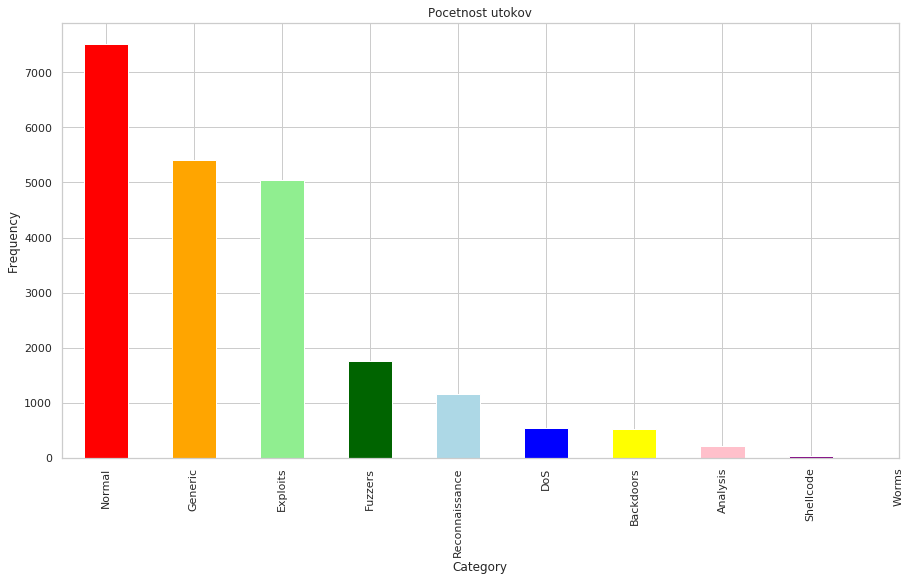

In [42]:
colors = ['red','orange','lightgreen','darkgreen','lightblue','blue','yellow','pink','purple'];
attacks=dataset.loc[dataset.attack_cat.apply(lambda x: x > 0)];
attacks.attack_cat.value_counts().plot(kind='bar', title='Pocetnost utokov', color=colors)
category_labels=['Normal','Generic','Exploits','Fuzzers','Reconnaissance','DoS','Backdoors','Analysis','Shellcode','Worms'];
plt.xticks(range(len(category_labels)), category_labels)
plt.xlabel("Category")
plt.ylabel("Frequency")

In [43]:
dataset.state.value_counts()

FIN    487911
CON    187503
INT     21797
REQ      2425
CLO       111
URH       108
RST        74
ECO        26
ACC        22
PAR         2
URN         1
TST         1
MAS         1
TXD         1
ECR         1
Name: state, dtype: int64

In [0]:
states_mapping = {"FIN": 1, "CON": 2, "INT": 3, "REQ": 4, "CLO": 5, "URH": 6, "RST": 7, "ECO": 8, "ACC": 9, "PAR": 10, "URN": 11, "ECR": 12, "TST": 13, "TXD": 14, "MAS": 15};
dataset = dataset.replace({'state': states_mapping})

In [45]:
dataset.service.value_counts()

NUSER       430639
dns         121170
http         55858
ftp-data     37305
smtp         23588
ftp          16531
ssh          14636
pop3           206
ssl             20
snmp            14
radius           7
dhcp             7
irc              3
Name: service, dtype: int64

In [0]:
services_mapping = {"dns": 53, "NUSER": 256, "http": 80, "smtp": 25, "ftp-data": 20, "ftp": 21, "ssh": 22, "pop3": 110, "snmp": 161, "ssl": 443, "irc": 6697, "radius": 1812, "dhcp": 68};
dataset = dataset.replace({'service': services_mapping})

In [0]:
service_col=dataset.service;
dataset=dataset.drop(columns='service');
dataset.insert(6, "service",service_col);

In [0]:
dataset.insert(1, "srciploc", "")
dataset.insert(5, "dstiploc", "")

In [0]:
dataset.srciploc=dataset.srcip.apply(lambda x: getIPLocation(x));
dataset.dstiploc=dataset.dstip.apply(lambda x: getIPLocation(x));

In [0]:
dataset.reindex()
dataset.index = range(len(dataset))

In [51]:
print("Features before OHE: {}".format(dataset.shape[1]));

ohe_srciploc = pd.get_dummies(dataset.srciploc,prefix='srciploc')
dataset = pd.concat([dataset, ohe_srciploc], axis=1)

ohe_dstiploc = pd.get_dummies(dataset.dstiploc,prefix='dstiploc')
dataset = pd.concat([dataset, ohe_dstiploc], axis=1)

dataset = dataset.drop(columns=['srciploc','dstiploc','srcip','dstip'])

print("Features after OHE: {}".format(dataset.shape[1]));

Features before OHE: 53
Features after OHE: 59


Text(0, 0.5, 'Frequency')

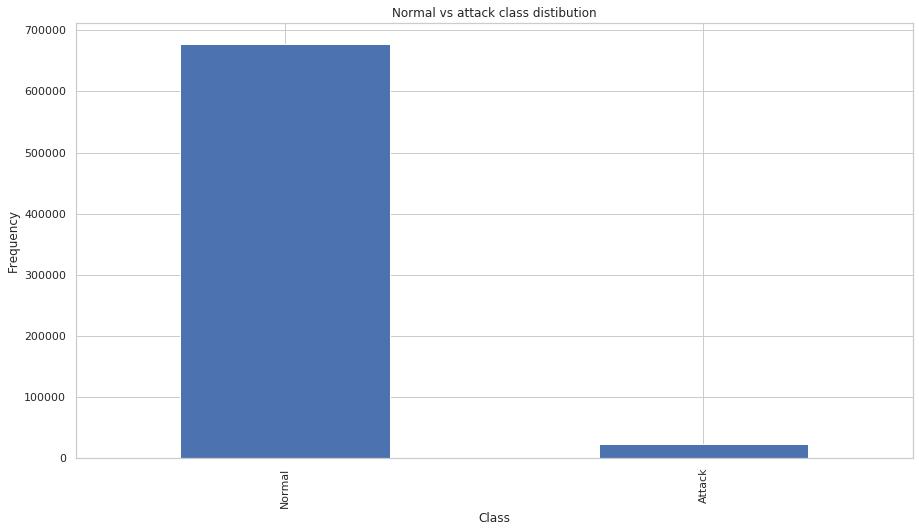

In [53]:
count_classes = pd.value_counts(dataset.Label)
count_classes.plot(kind="bar")
plt.title("Normal vs attack class distibution")
plt.xticks(range(2), ["Normal","Attack"])
plt.xlabel("Class")
plt.ylabel("Frequency")

In [54]:
attack_traffic=dataset[dataset.Label.apply(lambda x: x==1)]
normal_traffic=dataset[dataset.Label.apply(lambda x: x==0)]
print(normal_traffic.shape, attack_traffic.shape)

(677769, 59) (22215, 59)


In [0]:
backup_dataset=dataset

In [0]:
dataset = dataset.drop(columns=['Label'])

In [0]:
attac_cat_col = dataset.attack_cat;
dataset_without_labels = dataset.drop(columns=['attack_cat'])
#unchanged_dataset = dataset[dataset.columns[:8]]

#dataset_norm = dataset_without_labels[dataset_without_labels.columns[8:]]
dataset_norm = dataset_without_labels
names = dataset_norm.columns

scaler = preprocessing.StandardScaler()
scaled_dataset = scaler.fit_transform(dataset_norm)
scaled_dataset = pd.DataFrame(scaled_dataset, columns=names)
dataset_norm.update(scaled_dataset)

#norm_dataset = pd.concat([unchanged_dataset, dataset_norm.reindex(unchanged_dataset.index)], axis=1)
dataset_norm['attack_cat'] = attac_cat_col

dataset = dataset_norm

In [59]:
X = dataset.drop('attack_cat', axis=1)
Y = dataset.attack_cat

print(X.shape, Y.shape)

(699984, 57) (699984,)


In [60]:
total_features=dataset.shape[1];
total_rows=dataset.shape[0];
normal_traffic_rows=normal_traffic.shape[0];
normal_traffic_per=(100*normal_traffic_rows)/total_rows;
attack_traffic_rows=attack_traffic.shape[0];
attack_traffic_per=(100*attack_traffic_rows)/total_rows;

print("Total rows: {}\nTotal features: {}\nNormal traffic: {} ({} %)\nAttack traffic: {} ({} %)".format(total_rows, total_features, normal_traffic_rows, normal_traffic_per, attack_traffic_rows, attack_traffic_per));

Total rows: 699984
Total features: 58
Normal traffic: 677769 (96.826356030995 %)
Attack traffic: 22215 (3.173643969005006 %)


In [0]:
print("Original dataset categories shape {}".format(sorted(Counter(Y).items())))

pipe = make_pipeline(SMOTE(sampling_strategy='auto',random_state=41,n_jobs=5), ADASYN(sampling_strategy='auto',random_state=41,n_jobs=5))
X_resampled, Y_resampled = pipe.fit_resample(X,Y)

X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_dataset = X_resampled_df.assign(attack_cat=pd.Series(Y_resampled))

print(X_resampled.shape, Y_resampled.shape)
print("Original dataset categories shape {}".format(sorted(Counter(Y).items())))
print("Resampled dataset categories shape {}".format(sorted(Counter(Y_resampled).items())))

In [0]:
corrmat = dataset.corr()
top_corr_features = corrmat.index
pl.figure(figsize=(60,60))
g=sns.heatmap(dataset[top_corr_features].corr(method='pearson', min_periods=1),annot=True,cmap="RdYlGn")

In [0]:
#--------------------------------------------------------------------

In [0]:
test=dataset[dataset.sbytes.astype(int).apply(lambda x: x>450)]
print("Source to destination transaction bytes");
print("Normal traffic: {}".format(test[test.label.apply(lambda x: x==0)].shape));
print("Attack traffic: {}".format(test[test.label.apply(lambda x: x==1)].shape))

In [0]:
makePlot(dataset.index.astype(int),dataset.sbytes,"Source to destination transaction bytes",450);

In [0]:
test=dataset[dataset.dbytes.astype(int).apply(lambda x: x>650)]
print("Destination to source transaction bytes");
print("Normal traffic: {}".format(test[test.Label.apply(lambda x: x==0)].shape));
print("Attack traffic: {}".format(test[test.Label.apply(lambda x: x==1)].shape))

In [0]:
makePlot(dataset.index.astype(int),dataset.dbytes,"Destination to source transaction bytes",650);

In [0]:
#sbytes,dbytes and sloss,dloss are in corelation (probably - check it out). All the records are attacs and due to that can not be removed.

#450 for sloss
#650 for dloss

#Data normalization should be applied to sbytes, sloss, dloss, sttl, dttl